In [5]:
import pandas as pd 
import numpy as np 
import torch 

In [6]:
df = pd.read_csv('fmnist_small.csv')
df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,9,0,0,0,0,0,0,0,0,0,...,0,7,0,50,205,196,213,165,0,0
1,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,...,142,142,142,21,0,3,0,0,0,0
3,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,8,0,0,0,0,0,0,0,0,0,...,213,203,174,151,188,10,0,0,0,0


In [7]:
torch.manual_seed(42) # By fixing the seed (e.g., 42), PyTorch ensures that these random operations produce the same results every time you run the code.

In [8]:
# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


NameError: name 'df' is not defined

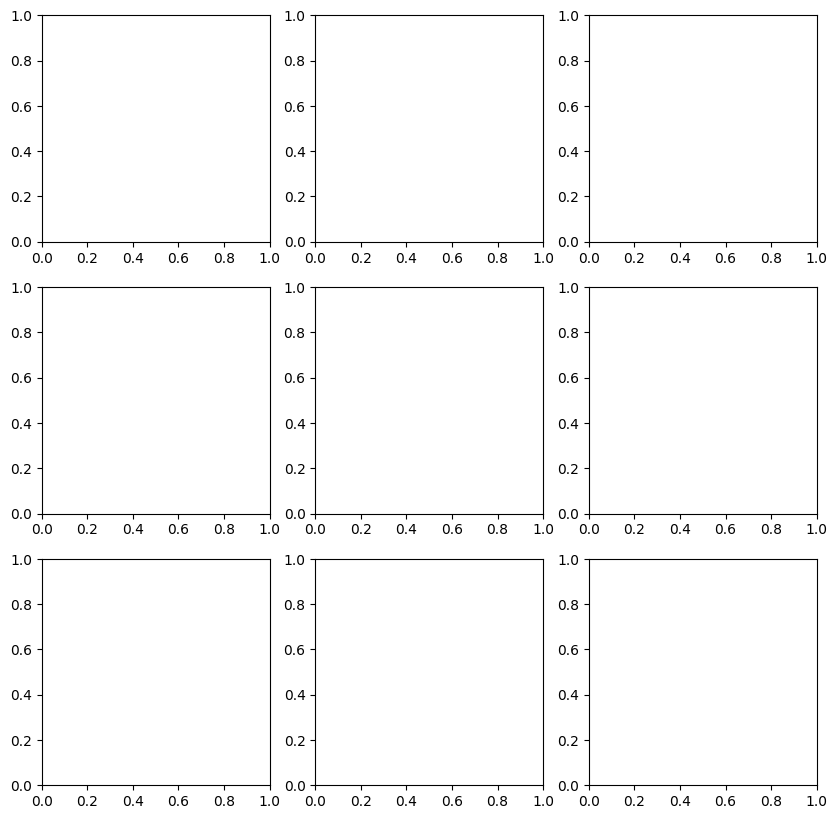

In [2]:
import matplotlib.pyplot as plt
fig, axes =  plt.subplots(3,3, figsize = (10,10))
for i, ax in enumerate(axes.flat): 
    img = df.iloc[i,1:].values.reshape(28,28)
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f"label:{df.iloc[i,0]}")

plt.tight_layout(rect=[0,0,1,0.96])
plt.show()

In [5]:
X = df.iloc[:,1:].values
y = df.iloc[:,0].values
y.shape

(6000,)

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

In [7]:
X_train_transformed = X_train/255.0 # ranging input featuers within 0<x<1
X_test_transformed = X_test/255.0

In [8]:
from torch.utils.data import Dataset, DataLoader 
class CustomDataset(Dataset): 
    def __init__(self, features, labels): 
        self.features = torch.tensor(features,dtype=torch.float32)
        self.labels = torch.tensor(labels,dtype=torch.long)

    def __len__(self): 
        return len(self.features)

    def __getitem__(self,index): 
        return self.features[index], self.labels[index]

In [9]:
train_dataset = CustomDataset(X_train_transformed,y_train)

In [10]:
test_dataset = CustomDataset(X_test_transformed, y_test)

In [11]:
len(test_dataset)

1200

In [12]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, pin_memory= True) #use pin_memory = True for huge dataset or RAM is full
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False,pin_memory= True) # false because we donot need to shuffle the row while testing because it cause different accuracy

In [32]:
import torch.nn as nn
class MyNN(nn.Module): 
    def __init__(self, num_featues): 
        super().__init__()
        self.model = nn.Sequential(
        nn.Linear(num_features, 128),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.Dropout(p=0.3),
        nn.Linear(128, 64),
        nn.BatchNorm1d(64),
        nn.ReLU(),
        nn.Dropout(p=0.3),
        nn.Linear(64, 10) # we didnot add softmax activation at last because pytorch's cross entropy loss has internal softmax implemented.
        )

    def forward(self,x): 
        return self.model(x)

In [33]:
epochs = 10
learning_rate = 0.1

In [34]:
import torch.optim as optim
#creating instance of NN clas
model = MyNN(X_train_transformed.shape[1])
model = model.to(device)# keeping model at GPU
#loss function
criterion = nn.CrossEntropyLoss()
# parameters updating algorithm
optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=1e-4) # weight decay for L2 regularization

In [35]:
len(train_loader)

150

In [36]:
for epoch in range(epochs): 
    total_epoch_loss = 0
    for batch_features, batch_labels in train_loader: 
        batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)# keeping data at GPU
        # forward pclassmethod
        outputs = model(batch_features)
        # loss 
        loss = criterion(outputs, batch_labels)
        # making gradient zero 
        optimizer.zero_grad()
        # back pass 
        loss.backward()
        # update grads
        optimizer.step()
        #total loss 
        total_epoch_loss += loss.item() 

    #average loss
    avg_epoch_loss = total_epoch_loss/len(train_loader)
    print(f"Epoch: {epoch+1}, Loss:{avg_epoch_loss}")
        

Epoch: 1, Loss:1.766981213092804
Epoch: 2, Loss:0.9239565598964691
Epoch: 3, Loss:0.7619694381952286
Epoch: 4, Loss:0.6756169931093852
Epoch: 5, Loss:0.606735162337621
Epoch: 6, Loss:0.5684249838193257
Epoch: 7, Loss:0.5152535485227903
Epoch: 8, Loss:0.4852886187036832
Epoch: 9, Loss:0.4731327482064565
Epoch: 10, Loss:0.4516912885506948


In [37]:
model.eval()
# we need to explicitly define it because model behave differently in training and evaluating process like dropout neuron and so on

MyNN(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=10, bias=True)
  )
)

In [38]:
len(test_loader)

38

In [39]:
a = torch.tensor([1,2,3,4,5,6])
b= torch.tensor([0,2,3,8,5,0])
(a==b).sum().item()

3

In [40]:
total = 0
correct = 0
with torch.no_grad(): 
    for batch_features, batch_labels in test_loader: 
        batch_features, batch_labels = batch_features.to(device), batch_labels.to(device) # keeping data at GPU
        outputs = model(batch_features)
        # max_values, max_indices = torch.max(outputs, 1) and we donot need the max_values so we put _ there.
        _, predicted_index = torch.max(outputs,1) # 1 is for accros columns
        total = total + batch_labels.shape[0]
        correct = correct + (predicted_index==batch_labels).sum().item()
print(correct/total)

0.8066666666666666
